# 1 Environment
- Python version: 3.11.7  
- OS: Windows 11  
- Environment: Visual Studio Code

### Packages
- pandas
- .. zu erweitern, eventuell Requirements.txt

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 2 Load Data 
Describe in detail their origin, content, structures and data types.

In [2]:
url  = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=";")
print(df.describe(include='all'))
y = df['quality']


       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

### Wine Quality (Duc)

origin= archive.ics.uci.edu

        - UC Irvine, Maschine Learning Repository
        - has 683 datasets currently

content = 
- data length is 1599 = count
- 12 kinds of features:  
    - fixed acidity :  
            - min   4.60  
            - max   15.9  
            - mean  8.3  
            - std   1.7  
            -> huge differenz, but that might be an exception  
            -> mostly around 8.3 with 1.7 deviation : 7-10  
    - volatile acidity :  
            - min   0.12  
            - max   1.58  
            - mean  0.527 ~ 0.53  
            - std   0.179 ~ 0.18  
    - citric acid :  
            - min   0.0  
            - max   1.0  
            - mean  0.27  
            - std   0.19  
    - residual sugar:  
            - min   0.9  
            - max   15.5  
            - mean  2.538 ~ 2.54  
            - std   1.40  
              
  several features/themes related to the wine: chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, quality  
- all have these subfeatures: count, mean, std, min, 25%,50%,75%,max
- categories focus on wine content, what its made of
structures = 
    - 3x4 columns
    - the subfeatures on the left side 
    - maybe categorized? 

data types =  only float numbers can be seen, except 1 int.



# 3  Data Exploration
Prepare statistical and visual data summaries.  

How many variables/features does the data contain, how many samples? Are there missing values? Explore correlations among variables and conduct at least one unsupervised analysis. Consider variable transformations and normalizations where applicable.


In [3]:
print("Missing Values in each column:")
print(df.isna().sum())
# 12 features/variables 
# no missing values
# all numerical, all float, 1 int (quality)
# 1599 samples/rows
(print("Statistical Summary:"))
print(df.info())
print(df.shape)

#Correlation neutral, positive, negative: df.corr()
#one unsupervised analysis
#variable transformations and normalizations where capable

Missing Values in each column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
Statistical Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   p

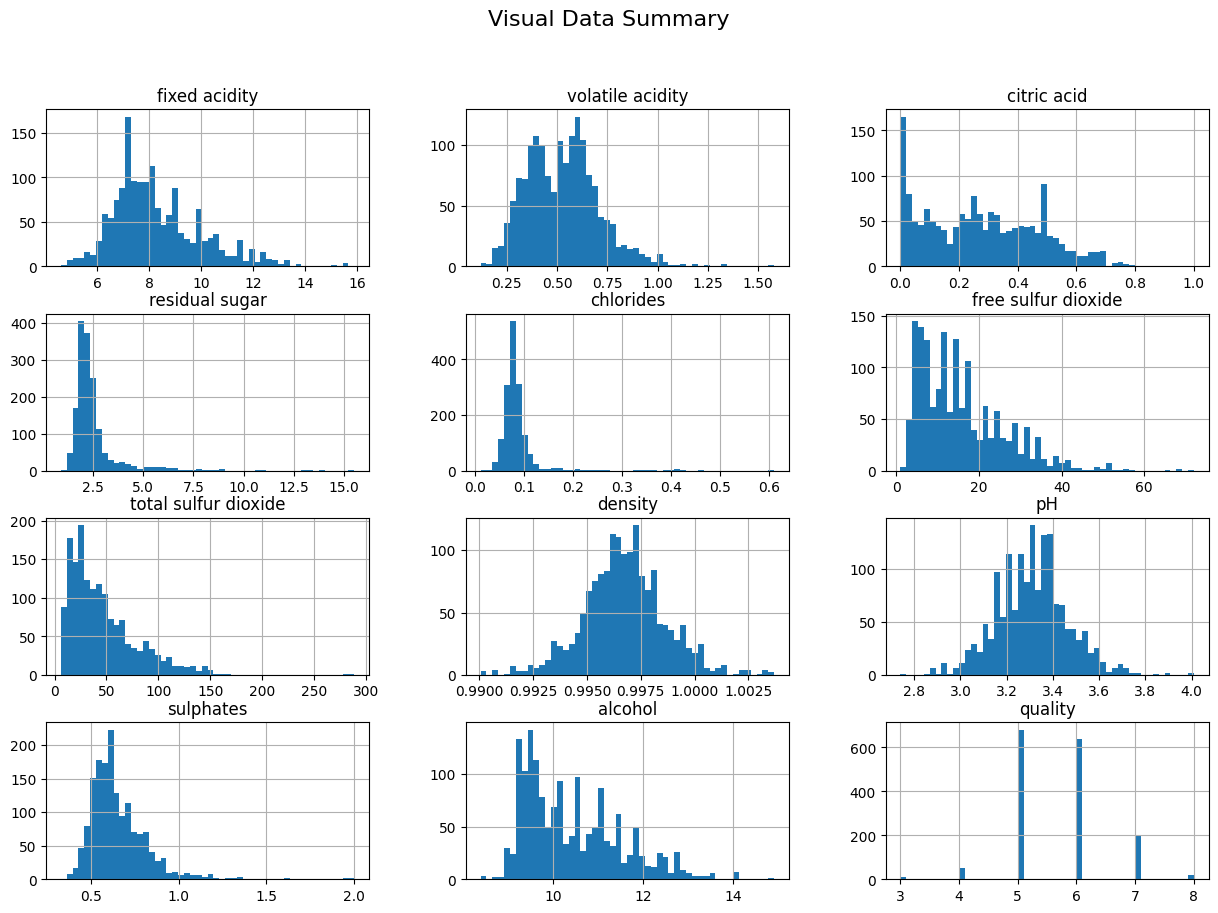

In [4]:
df.hist(figsize=(15,10), bins=50) #bins anpassen
plt.suptitle("Visual Data Summary", fontsize=16)
plt.show()
#Motivation: see distributions of features individually -> clear to see skewness, outliers, normality, less chaos

#none equally distributed
#some skewed right: residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide
#some approx normal: fixed acidity, citric acid, pH, sulphates, alcohol
#some approx uniform: volatile acidity, density 

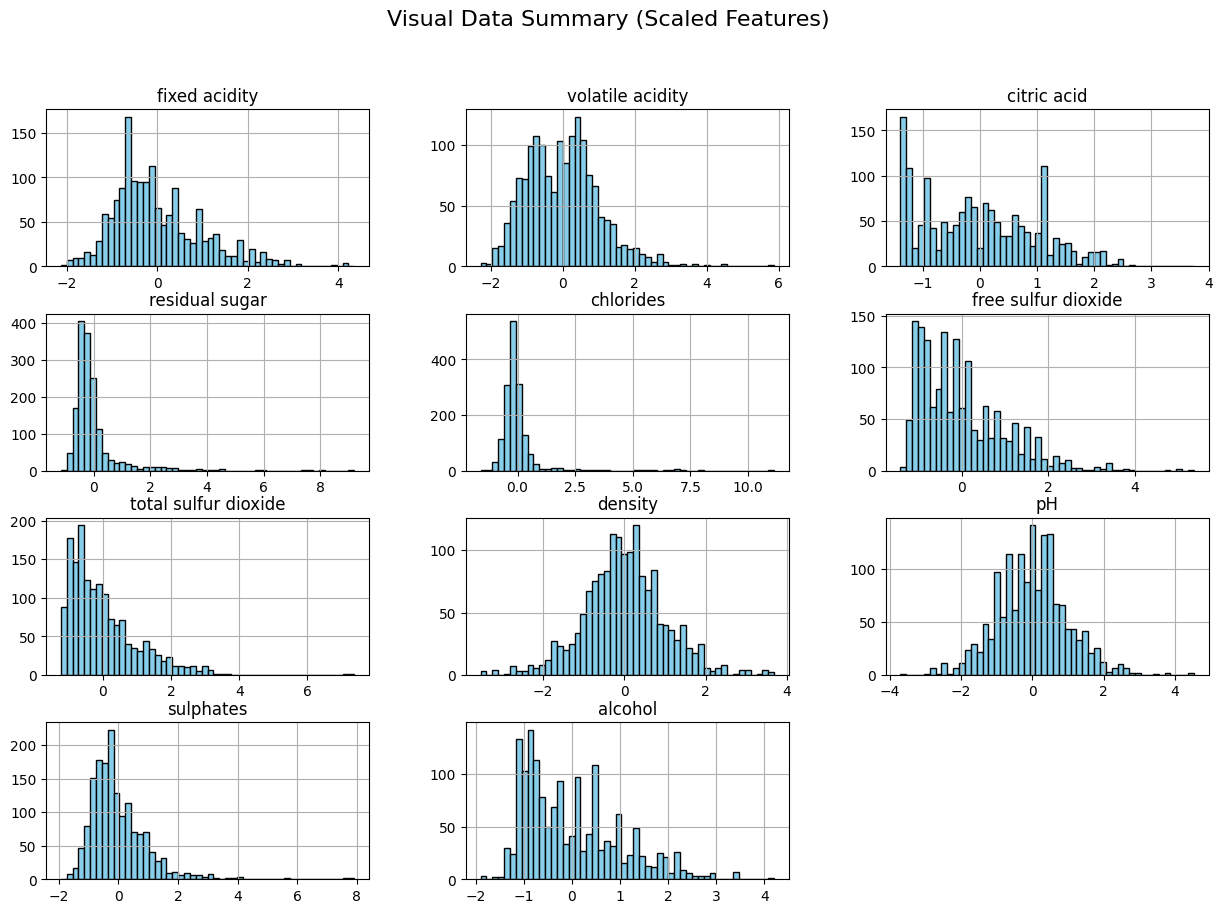

In [5]:
#normalization

features = ["fixed acidity", "volatile acidity", "citric acid", 
            "residual sugar", "chlorides", "free sulfur dioxide",
            "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]

X = df[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df_scaled = pd.DataFrame(X_scaled, columns=features)

df_scaled.hist(figsize=(15,10), bins=50, color='skyblue', edgecolor='black')
plt.suptitle("Visual Data Summary (Scaled Features)", fontsize=16)
plt.show()

### Correlations between all features (Duc)

If the value rises proportional to the risen value of quality, then it's a positive correlation.  
If the value drops proportional to the sunken value of quality, then its a negative correlation.  
If they are irrelevant to each other, then its a neutral correlation.  

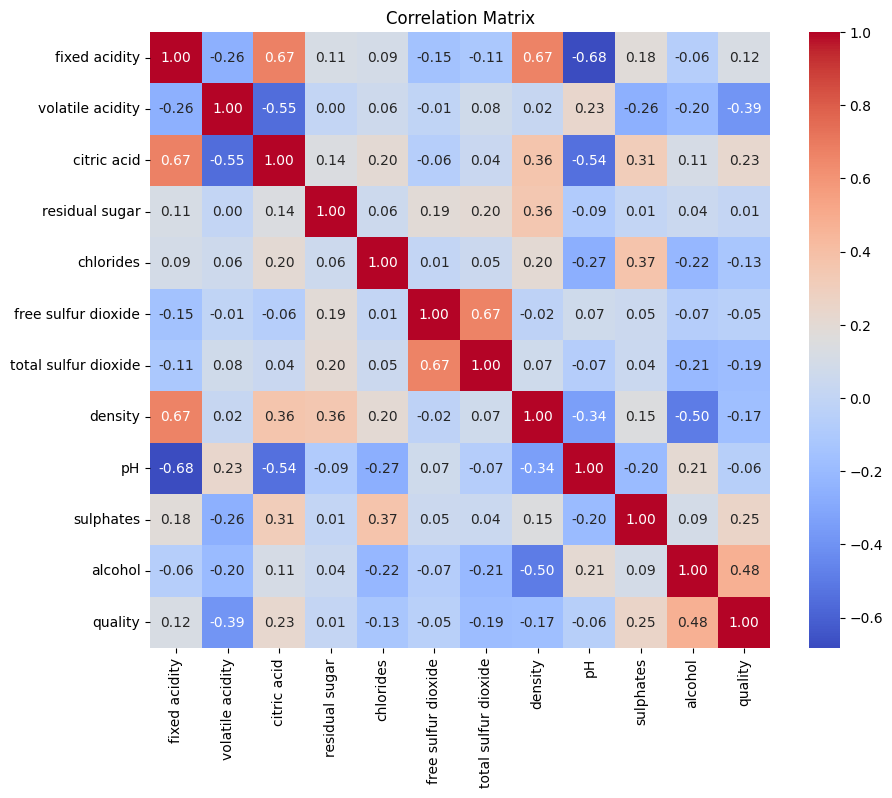

In [6]:
corr_matrix = df.corr('pearson')
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Correlation with the feature "quality" (Duc)

In [7]:
corr_with_quality = corr_matrix["quality"].sort_values(ascending=False)
print(corr_with_quality) #y is also quality


quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64


None of the features is neutral to quality.
Ex.: If quality rises by 1, then residual sugar rises by 0.013732
#maybe visualize? histogramm/pairplot  

transformation:
- stretch numbers - smaller ones get bigger and vice versa
Normalisation:
- squash numbers between 0-1 - same scale

-> better for algorithmens to understand

### Visualization of Correlation with Quality (Cathy)

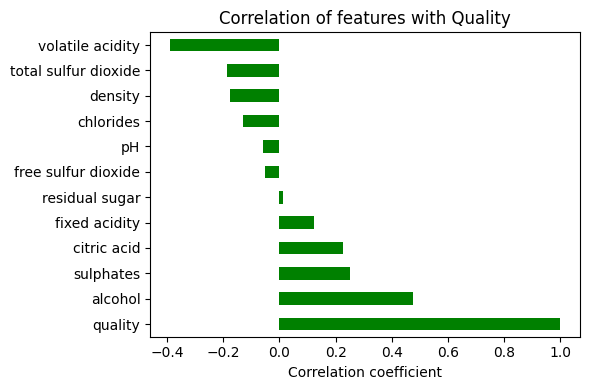

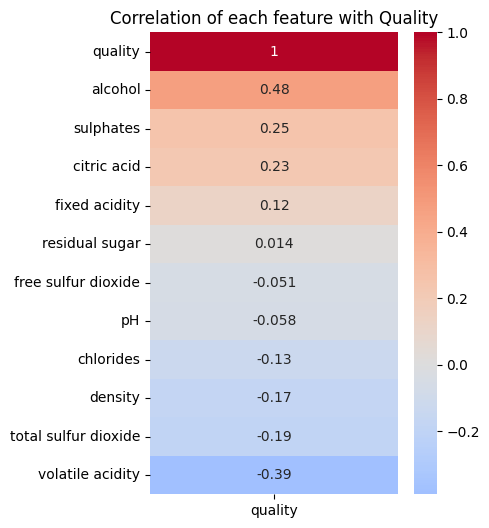

In [8]:
plt.figure(figsize=(6,4))
corr_with_quality.plot(kind='barh', color='green')
plt.title("Correlation of features with Quality")
plt.xlabel("Correlation coefficient")
plt.tight_layout()
plt.show()

corr = df.corr(numeric_only=True)[["quality"]].sort_values(by="quality", ascending=False)

plt.figure(figsize=(4,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation of each feature with Quality")
plt.show()

### Distribution of Wine Quality Values (Cathy)

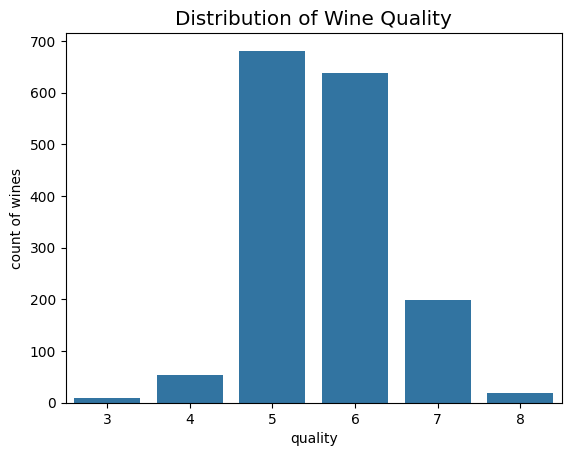

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [9]:
sns.countplot(x="quality", data=df)                    #zählt die Einträge in Quality für jeden Wert
plt.style.use("ggplot")
plt.title("Distribution of Wine Quality")
plt.xlabel("quality")
plt.ylabel("count of wines")
plt.show()

plt.style.available  

### Log Transformation for every suitable Feature (Cathy)

As seen in the histograms below, the log-transformation reduces skewness. That means the large value range has been compressed.

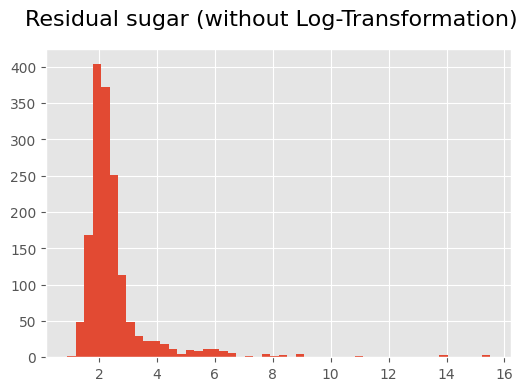

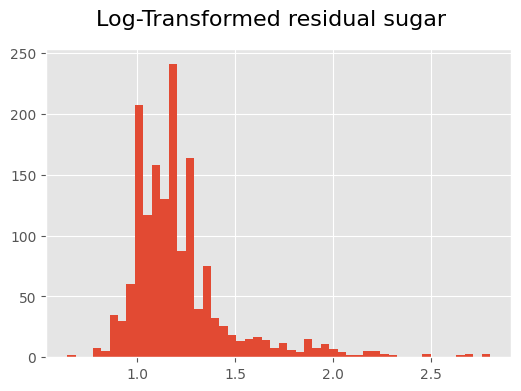

vlues before log transformation
count    1599.000000
mean        2.538806
std         1.409928
min         0.900000
25%         1.900000
50%         2.200000
75%         2.600000
max        15.500000
Name: residual sugar, dtype: float64


values after log transformation
count    1599.000000
mean        1.218131
std         0.269969
min         0.641854
25%         1.064711
50%         1.163151
75%         1.280934
max         2.803360
Name: residual sugar, dtype: float64


In [10]:
#Kopie damit Original nicht manipuliert wird
showcase_df = df.copy()

df["residual sugar"].hist(figsize=(6,4), bins=50)
plt.suptitle("Residual sugar (without Log-Transformation)", fontsize=16)
plt.show()


showcase_df['residual sugar'] = np.log1p(showcase_df['residual sugar'])
showcase_df["residual sugar"].hist(figsize=(6,4),bins=50)
plt.suptitle("Log-Transformed residual sugar", fontsize=16)
plt.show()

print("vlues before log transformation")
print(df["residual sugar"].describe())
print("\n")
print("values after log transformation")
print(showcase_df["residual sugar"].describe())
#log transformation to reduce skewness of residual sugar
#makes it more evenly distributed 
#more beautiful

In the following code block, we apply this log-transformation to any feature whose skewness is greater than or equal to 1.

In [11]:
#zur Bestimmung, ob Transformation nötig ist
log_features = []
for feat in features:
    skew = df[feat].skew()
    if skew >= 1:
        log_features.append(feat)

    '''
    print(feat)
    print("Skewness vor:", df[feat].skew())
    print("Skewness nach:", np.log1p(df[feat]).skew())
    print("\n")
    '''
print("Relevant Features:\n")
for i in log_features:
    print(i)

Relevant Features:

residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
sulphates


In [12]:
#Kopie des ursprünglichen Dataframes
df_transformed = df.copy()

for logfeat in log_features:
    #neue Werte für transformierte Features
    df_transformed[logfeat] = np.log1p(df[logfeat])

#features OHNE Quality
features = ["fixed acidity","volatile acidity","citric acid",
            "residual sugar","chlorides","free sulfur dioxide",
            "total sulfur dioxide","density","pH","sulphates","alcohol"]

X = df_transformed[features]
Xs = scaler.fit_transform(X) #nur auf X (also alle deklarierten features) skalieren NICHT auf quality

df_scaled = pd.DataFrame(Xs, columns=features, index=X.index)
df_scaled_long = df_scaled.melt(var_name="Feature", value_name="Value")


### Unsupervised Clustering (Cathy)

The following plots show the correlation between features with the addition of differentiating between clusters. We can see a lot of overlapping between the clusters, but the overall picture is not entirely clear. Also there are way too many subplots to analyse.

c:\Users\cathy\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\cathy\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


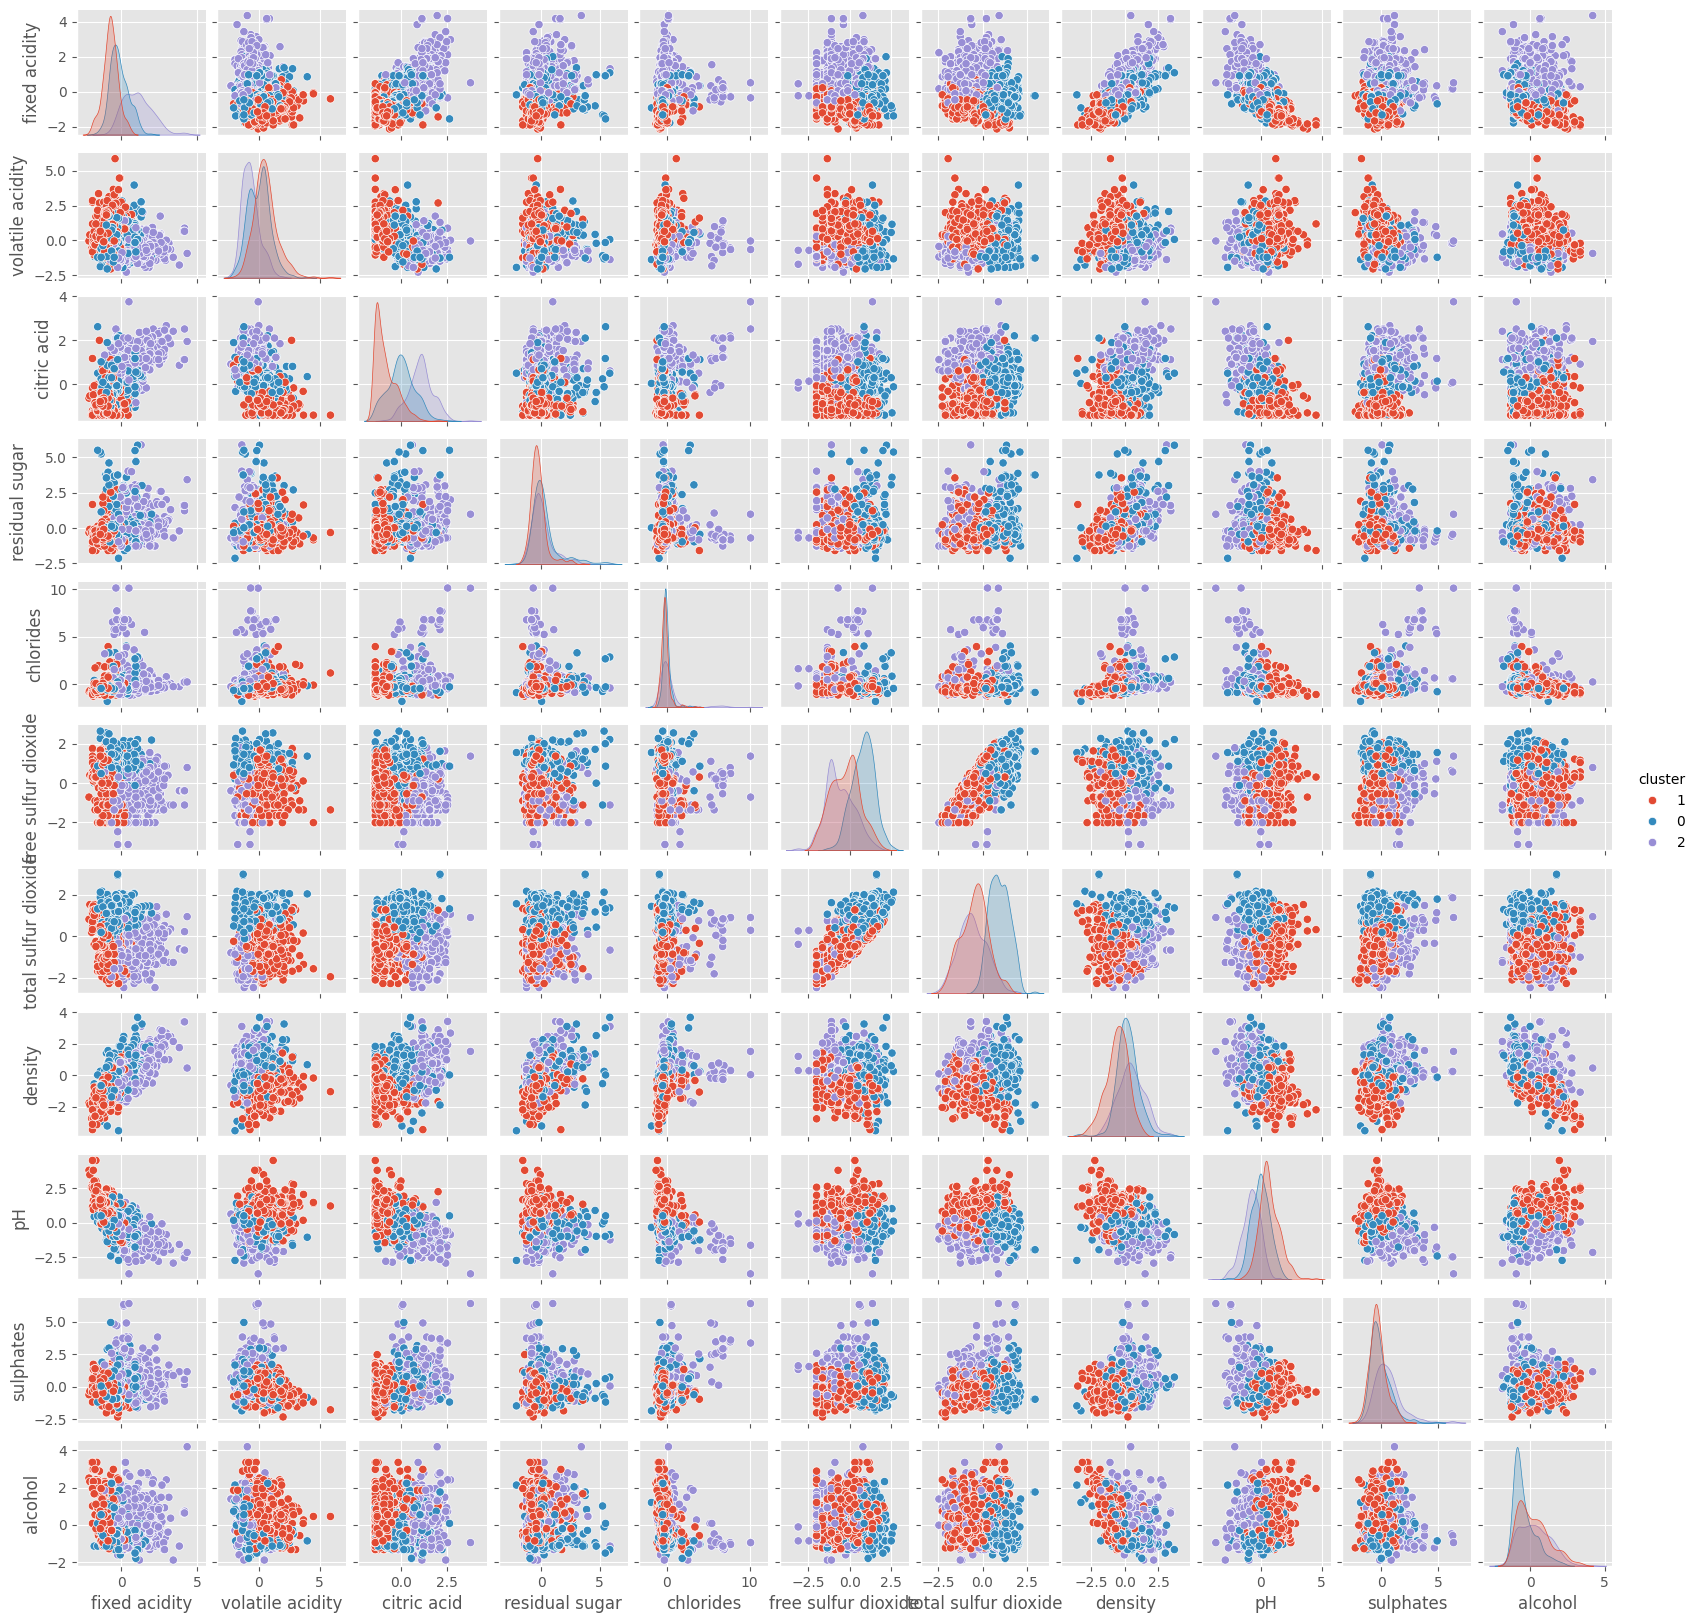

In [13]:
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(Xs)

df_scaled["cluster"] = labels.astype(str)

sns.pairplot(df_scaled, hue="cluster", height=1.5, aspect=1.0)


To visualize the clusters better, we can compress the dataframe to lesser dimensions. Here we chose 2 dimensions. This plot shows, that the prior calculated 3 clusters indeed show a distinct seperation.

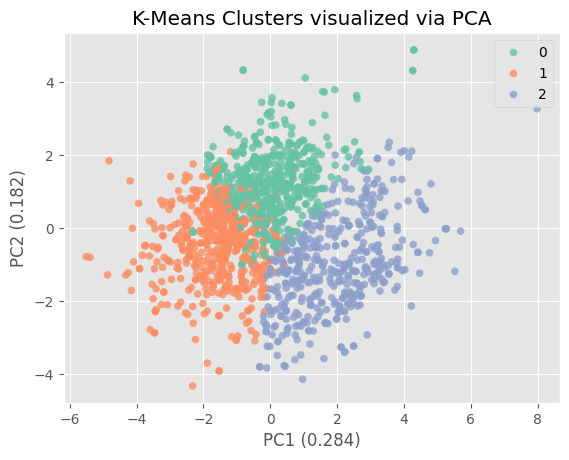

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xs)
var_exp = pca.explained_variance_ratio_

xlab = f"PC1 ({var_exp[0]:.3f})"
ylab = f"PC2 ({var_exp[1]:.3f})"

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                hue=labels, palette="Set2", s=30, edgecolor="none", alpha=0.8)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.title("K-Means Clusters visualized via PCA")
plt.show()

Another approach to see which feataures are more prominent in which cluster is by defining the mean of each cluster for each feature. This way we can not only see differences between the clusters, but also which feature is relatively high or low in which cluster. 
The following heatmap shows for example a high value for fixed acidity and citric acid in one cluster while another shows a very low value of these two.

         fixed acidity  volatile acidity  citric acid  residual sugar  \
cluster                                                                 
0            -0.140345          0.011121     0.001363        0.247358   
1            -0.720235          0.537227    -0.847353       -0.294456   
2             1.059243         -0.678462     1.047564        0.069464   

         chlorides  free sulfur dioxide  total sulfur dioxide   density  \
cluster                                                                   
0        -0.039462             0.794081              0.953482  0.206206   
1        -0.218009            -0.281575             -0.459855 -0.580548   
2         0.317022            -0.598799             -0.568240  0.472801   

               pH  sulphates   alcohol  
cluster                                 
0       -0.048233  -0.135681 -0.431455  
1        0.700230  -0.321896  0.195064  
2       -0.809475   0.560457  0.273255  


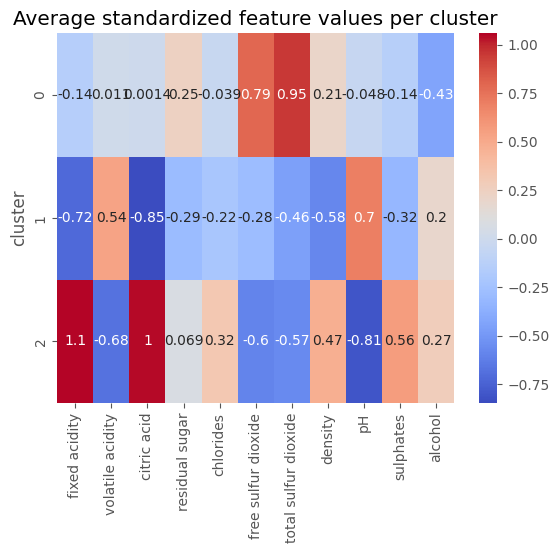

In [15]:
cluster_means = df_scaled.groupby("cluster").mean()
print(cluster_means)

sns.heatmap(cluster_means, cmap="coolwarm", annot=True)
plt.title("Average standardized feature values per cluster")
plt.show()

To see if Clusters show differences in quality, we can compare these two features within a crosstable. Cluster 2 for example has a lot more datasets for quality value 7 than the other two. This could lead to the assumption, that correlations between other features could predict the quality of a wine.

In [16]:
pd.crosstab(df["quality"], df_scaled["cluster"])

cluster,0,1,2
quality,,,
3,1,7,2
4,12,33,8
5,325,228,128
6,184,248,206
7,34,54,111
8,0,7,11


# 4 Data Model
Define what you want to model (following the table below) and choose an appropriate model framework. Define a simple baseline model and a loss function - theoretically and practically. Explain the model in terms of input-output data structures and dimensions.

### Supervised Learning: Linear Model x -> y

# 5 Train Model
Define a Train Define Train and Test Data and run the training loop. Monitor the behaviour of the loss function.

# 6 Evaluate Model
Run model predictions on the test data set. Calculate and visualize the appropriate metrics to evaluate model performance. Explain why a separate test data set should be used for such evaluations.

# 7 Improve Model
Suggest extensions to your baseline model and repeat steps 4. - 6. Do these extensions improve the model?